## Welcome!

In notebook we calculate Stored Carbon from an ISRIC dataset, more specifically the ISRIC-WISE Harmonized Global Soil Profile Dataset v3.1 available here: https://data.isric.org/geonetwork/srv/eng/catalog.search#/metadata/a351682c-330a-4995-a5a1-57ad160e621c"

The dataset (in MS Access format) was downloaded and split into .csv files, available in a .zip here:

https://drive.google.com/file/d/1wuhyplJ7klD4hV7BsAGSalnXjc5a4GK4/view?usp=sharing

In [1]:
using Pkg

In [13]:
Pkg.add(["Plots","DataFrames", "CSV", "Query", "StatsBase", "DataInterpolations"])

  Resolving package versions...
No Changes to `~/Project.toml`
No Changes to `~/Manifest.toml`


In [7]:
Pkg.precompile()

Precompiling project...
┌ Info: Precompiling CSV [336ed68f-0bac-5ca0-87d4-7b16caf5d00b]
└ @ Base loading.jl:1278
┌ Info: Precompiling Query [1a8c2f83-1ff3-5112-b086-8aa67b057ba1]
└ @ Base loading.jl:1278
┌ Info: Precompiling StatsBase [2913bbd2-ae8a-5f71-8c99-4fb6c76f3a91]
└ @ Base loading.jl:1278
┌ Info: Precompiling Plots [91a5bcdd-55d7-5caf-9e0b-520d859cae80]
└ @ Base loading.jl:1278
┌ Info: Precompiling DataInterpolations [82cc6244-b520-54b8-b5a6-8a565e85f1d0]
└ @ Base loading.jl:1278


In [14]:
using Plots, DataFrames, CSV, Query, StatsBase, DataInterpolations

Let's import the soil horizon data:

In [12]:
df_horizon = CSV.read(download("https://drive.google.com/uc?export=download&id=1dAHPZfm8KIXC9qVks-owkD0LYbZjPpIM"), DataFrame)

thread = 1 warning: only found 30 / 31 columns around data row: 47834. Filling remaining columns with `missing`


,WISE3_ID,HONU,DESIG,TOPDEP,BOTDEP,MCOLOR,DCOLOR,ORGC,TOTN,CACO3
,String,Int64,String?,Int64,Int64,String?,String?,String?,String?,String?
1,AF0001,1,missing,0,15,10YR4/3,10YR4/2,"7,6","0,6",93
2,AF0001,2,missing,15,60,10YR5/3,10YR5/2,"2,3","0,3",177
3,AF0001,3,missing,60,150,10YR5/3,missing,"0,9","0,3",182
4,AF0002,1,missing,0,20,10YR4/2,missing,"12,8","0,9",191
5,AF0002,2,missing,20,60,10YR4/2,missing,6,"0,6",192
6,AF0002,3,missing,60,110,10YR4/3,missing,"3,9","0,6",203
7,AF0002,4,missing,110,170,10YR4/3,missing,"2,7",missing,240
8,AF0003,1,A,0,20,10YR4/2,missing,"5,9","0,7",169
9,AF0003,2,Bg,20,50,10YR4/2,missing,"2,4","0,4",138


Some cleaning is necessary:

In [16]:
#keep only columns of interest

filt_hz = @from i in df_horizon begin
    @select {i.WISE3_ID, i.HONU, i.DESIG, i.TOPDEP, i.BOTDEP, i.ORGC, i.BULKDENS}
    @collect DataFrame end

#remove rows with missing data    
    dropmissing!(filt_hz,:BULKDENS)	
    dropmissing!(filt_hz,:ORGC)
    dropmissing!(filt_hz,:DESIG)

#turn BULKDENS and ORGC into Float64
    filt_hz.BULKDENS = tryparse.(Float64,replace.(filt_hz.BULKDENS,','=>'.'))
    filt_hz.ORGC = tryparse.(Float64,replace.(filt_hz.ORGC,','=>'.'))
    filt_hz

,WISE3_ID,HONU,DESIG,TOPDEP,BOTDEP,ORGC,BULKDENS
,String,Int64,String,Int64,Int64,Float64,Float64
1,AL0007,1,Ap,0,25,9.8,1.64
2,AL0007,2,AB,25,49,7.8,1.62
3,AL0007,3,Bw1,49,83,5.9,1.57
4,AL0007,4,Bw2,83,116,6.9,1.63
5,AL0007,5,2C1,116,147,4.6,1.56
6,AL0007,6,2C2,147,160,4.6,1.45
7,AL0008,1,Ap-,0,17,11.5,1.61
8,AL0008,2,Bw1,17,38,8.1,1.55
9,AL0008,3,2Bw2,38,66,1.7,1.18


Let's take a peek at ORGC and BULKDENS for the first profile:

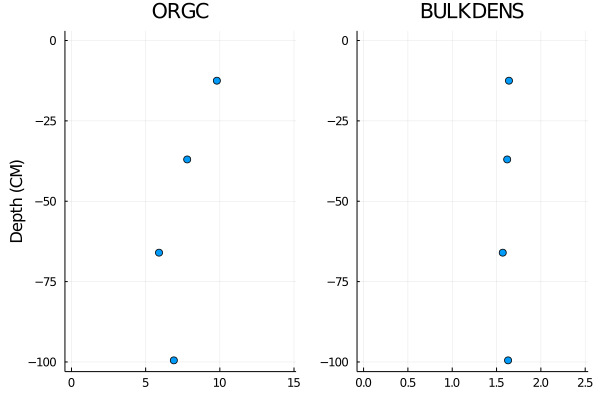

In [19]:

profile = filt_hz[filt_hz.WISE3_ID.=="AL0007",:]

td = profile.TOPDEP
bp = profile.BOTDEP

y_mid = (td .+ bp)./2 #as if each measurement was taken midway between TOP and BOT depths

blk = profile.BULKDENS
orgc = profile.ORGC

s1 = scatter(orgc,-y_mid,legend=nothing,xlim=[0,maximum(orgc)*1.5], ylim=[-100,0], title="ORGC", ylabel="Depth (CM)")

s2 = scatter(blk,-y_mid,legend=nothing,xlim=[0,maximum(blk)*1.5], ylim=[-100,0], title="BULKDENS")

plot(s1,s2)

As we have single-readings per section, and we want to estimate total storage for 1m of depth, I'm using a constant interpolation function to make things easier later on:

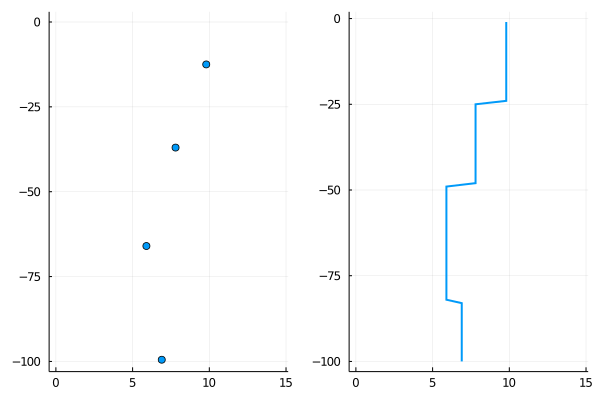

In [21]:

#merge TOP and BOT depth vectors
y_depth = sort!(cat(td,bp, dims=1))

#duplicate ORGC readings at each TOP/BOT end
orgc_ends = [orgc[Int(ceil(i/2))] for i in 1:length(orgc)*2] 

orgc_interp = ConstantInterpolation(orgc_ends,y_depth)
orgc_calc = orgc_interp.([i for i in 1:100])
#we're only gonna use values up to 1m of depth

p_original=scatter(orgc,-y_mid, legend=nothing, xlim=[0,maximum(orgc)*1.5], ylim=[-100,0])

p_interp = plot(orgc_calc,-[i for i in 1:100], legend=nothing, xlim=[0,maximum(orgc)*1.5], linewidth=2)

plot(p_original, p_interp)

Same for BULKDENS:

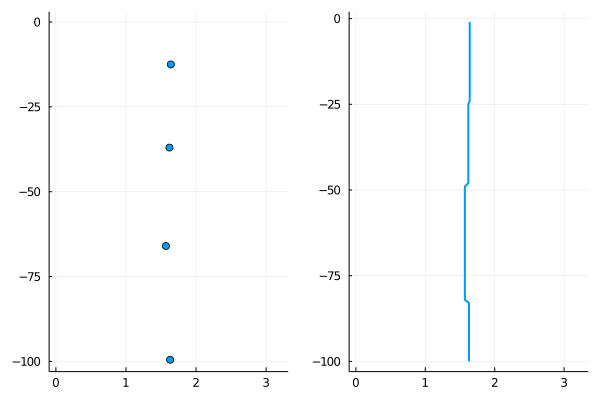

In [22]:

#duplicate BULKDENS readings at each TOP/BOT end
blk_ends = [blk[Int(ceil(i/2))] for i in 1:length(blk)*2] 

#the line above will generate i as 1 1 2 2 so to have double readings, 
#one for the beginning and the other for the end of the section between TOP and BOT

blk_interp = ConstantInterpolation(blk_ends,y_depth)
blk_calc = blk_interp.([i for i in 1:100])

p_orig_blk =scatter(blk,-y_mid, legend=nothing, xlim=[0,maximum(blk)+mean(blk)],ylim=[-100,0])

p_int_blk = plot(blk_calc,-[i for i in 1:100], legend=nothing, xlim=[0,maximum(blk_calc)+mean(blk_calc)], linewidth=2)

plot(p_orig_blk, p_int_blk)



As we have (interpolated) BULKDENS and ORGC values for each 1cm slice of soil, 
from 1cm to 100cm of depth, we can now calculate total ORGC stored for 1m³ of soil more easily.

Given the dataset, we'll have to calculate storage as:
BULKDENS [g / cm³] * VOLUME [m³] * ORGC [g / Kg]

The result will be in Kgs.

Generalizing the approach above, I define a function that I can call on each profile:

In [23]:
function orgc_storage(profile) 

top = profile.TOPDEP
bot = profile.BOTDEP

blk_t = profile.BULKDENS
orgc_t = profile.ORGC

#doubled vectors for use in interpolation
y_depth = sort!(cat(top,bot,dims=1)) 	
orgc = [orgc_t[Int(ceil(i/2))] for i in 1:length(orgc_t)*2] 
blk = [blk_t[Int(ceil(i/2))] for i in 1:length(blk_t)*2] 

#interpolation
orgc_interp = ConstantInterpolation(orgc,y_depth)
orgc_values = orgc_interp.([i for i in 1:100])

blk_interp = ConstantInterpolation(blk,y_depth)
blk_values = blk_interp.([i for i in 1:100])

#ORGC mass calculation
orgc_mass_array = Vector{Float64}(undef,0)

for i in 1:100
    push!(orgc_mass_array, blk_values[i]*orgc_values[i]*(1/100))
end

return sum(orgc_mass_array) 


end

orgc_storage (generic function with 1 method)

I call the function on each profile in the dataset, and order the result:

In [24]:
soil_profiles = unique(filt_hz.WISE3_ID)
orgc_mass_dict = Dict()

for profile in soil_profiles
    orgc_mass_dict[profile] = orgc_storage(filt_hz[filt_hz.WISE3_ID.==profile,:])
end

orgc_storage_df = sort!(DataFrame(WISE3_ID = String.(keys(orgc_mass_dict)), ORGC_ST_1M = Float64.(values(orgc_mass_dict))))

,WISE3_ID,ORGC_ST_1M
,String,Float64
1,AL0007,12.0638
2,AL0008,6.62788
3,AL0009,10.1866
4,AL0010,15.5469
5,AL0011,17.3051
6,AL0012,7.47206
7,AL0013,10.6143
8,AL0014,12.8286
9,AL0015,20.3039


The results can be accessed here:

https://drive.google.com/file/d/1aXIhLRsqk7Sybcy8SgZmMJorOTTNQLJ2/view?usp=sharing